<a href="https://colab.research.google.com/github/DreamTeamInc/Core-DS/blob/issues%2F2/research/Kern_EDA_Leon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Команда ниже монтирует образ gDrive. Добавь ярлык на папку с керном перед этим.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to 'sample_core_analysis_data_example' folder with folder name
SAMPLE_CORE_PATH = 'drive/My Drive/ sample_core_analysis_data_example'

Mounted at /content/drive


# Инициализация библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import copy

from skimage import io
# from skimage import exposure

pd.options.mode.chained_assignment = None

# Общий обзор данных

In [ ]:
data = pd.read_csv(SAMPLE_CORE_PATH + '/data.csv')
data

,task_id,photo_id,photo_type,segment_num,segment_type,segment_value
0,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,0,Свечение,Насыщенное
1,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,1,Свечение,Отсутствует
2,cfb8e7b2_7c98_4bd4_897d_0e5e95801bc9,1016625,УФ,0,Свечение,Карбонатное
3,a9d8f546_9046_46ce_ba17_abda344a0980,1013361,УФ,0,Свечение,Карбонатное
4,eb09a8aa_6c77_41de_8489_f5a390c789e8,1016727,УФ,0,Свечение,Карбонатное
...,...,...,...,...,...,...
14910,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,6,Разрушенность,Разлом
14911,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,7,Разрушенность,Разлом
14912,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,8,Разрушенность,Разлом
14913,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,9,Разрушенность,Разлом


In [ ]:
print('Типы фотографий - ', pd.unique(data['photo_type'].values))

Типы фотографий -  ['УФ' 'ДС']


In [ ]:
print('Типы сегментов - ', pd.unique(data['segment_type'].values))

Типы сегментов -  ['Свечение' 'Разрушенность' 'Порода']


In [ ]:
print('Классификации сегментов - ', pd.unique(data['segment_value'].values))

Классификации сегментов -  ['Насыщенное' 'Отсутствует' 'Карбонатное' 'Разлом' 'Аргиллит'
 'Переслаивание пород' 'Алевролит глинистый' 'Песчаник' 'Проба'
 'Глинисто-кремнистая порода' 'Песчаник глинистый' 'Уголь'
 'Аргиллит углистый' 'Алевролит' 'Карбонатная порода' 'Известняк'
 'Глина аргиллитоподобная']


**Note.** Как можно заметить ниже, сначала происходит сегсентация по 'типам', которые потом отдельно классифицируются.

In [ ]:
print('Свечение - ', pd.unique(data[data['segment_type'] == 'Свечение']['segment_value'].values))
print('Разрушенность - ', pd.unique(data[data['segment_type'] == 'Разрушенность']['segment_value'].values))
print('Порода - ', pd.unique(data[data['segment_type'] == 'Порода']['segment_value'].values))

Свечение -  ['Насыщенное' 'Отсутствует' 'Карбонатное']
Разрушенность -  ['Разлом' 'Проба']
Порода -  ['Аргиллит' 'Переслаивание пород' 'Алевролит глинистый' 'Песчаник'
 'Глинисто-кремнистая порода' 'Песчаник глинистый' 'Уголь'
 'Аргиллит углистый' 'Алевролит' 'Карбонатная порода' 'Известняк'
 'Глина аргиллитоподобная']


# Вспомогательные функции для изъятия файлов

In [ ]:
def show_image(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image)
    ax.axis('off')
    return fig, ax

def get_photo(data, i):
    return io.imread(SAMPLE_CORE_PATH + '/photos/{}.jpeg'.format(data['photo_id'].iloc[i]))

def get_mask(data, i):
    return np.load(SAMPLE_CORE_PATH + '/matrixes/matrix_{}__{}.npz'.format(data['photo_id'].iloc[i], data['task_id'].iloc[i]))['data']

def get_json(data, i):
    datastore = ''
    with open(SAMPLE_CORE_PATH + '/extra/extra_{}__{}.json'.format(data['photo_id'].iloc[i],
                                                                   data['task_id'].iloc[i]), 'r', encoding="utf8") as f:
        datastore = json.load(f)

    return datastore

def show_all(data, i):
    print(data.iloc[i])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
    ax1.imshow(get_photo(data, i))
    ax1.axis('off')

    cmap = plt.get_cmap('tab20b', np.max(get_mask(data, i)) + 1)
    mask = ax2.imshow(get_mask(data, i), cmap=cmap,
                      vmin=-0.5, vmax=np.max(get_mask(data, i))+0.5)
    ax2.axis('off')
    fig.colorbar(mask, ticks=np.arange(0, np.max(get_mask(data, i))+1))
    return fig, (ax1, ax2)



def show_photo_seies(data, column, value):
    fig, ax_ar = plt.subplots(1, 5, figsize=(14, 14))
    filt_data = data[data[column] == value]
    i = np.random.randint(0, filt_data.shape[0])
    for ax in ax_ar:
        filt_by_photo = filt_data[filt_data['photo_id'] == filt_data['photo_id'].iloc[i]]
        segments = filt_by_photo['segment_num'].values
        photo = get_photo(filt_data, i)
        mask = get_mask(filt_data, i)
        for value in segments:
            mask = np.ma.masked_where(mask == value, mask)
        
        ax.imshow(photo)
        ax.imshow(mask)
        ax.axis('off')
        filt_data.drop(filt_by_photo.index.values, axis=0, inplace=True)
        i = np.random.randint(0, filt_data.shape[0])
    
    return fig, ax_ar

# Визуализация данных

**Note.** Существуют фото с кол-вом сегментов больше 30 (ex. 1002)

In [ ]:
# show_all(data, 11000)

In [ ]:
# show_photo_seies(data, 'segment_value', 'Глина аргиллитоподобная')

In [ ]:
# show_photo_seies(data, 'segment_value', 'Переслаивание пород')

Похожие штуки:
1.   Аргиллит, Переслаивание пород, Алевролит глинистый, Песчаник (?), Песчаник глинистый 
2.   Карбонатная порода, Известняк, Глина аргиллитоподобная



# Более глубокая провека данных

Визуализация распределения ширины и высоты фотографий/масок

In [ ]:
def plot_shape_distribution(data):
    height = []
    width = []

    for index, row in data.iterrows():
        photo = get_photo(data, index)
        height.append(photo.shape[0])
        width.append(photo.shape[1])
    
    return sns.scatterplot(x=width, y=height, hue=data['photo_type'].to_numpy())

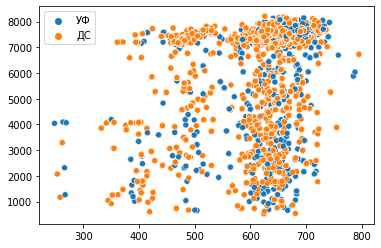

In [ ]:
plot_shape_distribution(data)

Расчёт соотношения 'УФ' фотографий к 'ДС' фотографиям в датасете

In [ ]:
data[data['photo_type'] == 'УФ'].shape[0]/data[data['photo_type'] == 'ДС'].shape[0]

0.13768115942028986

Визуализация распределения segment_value по датасету


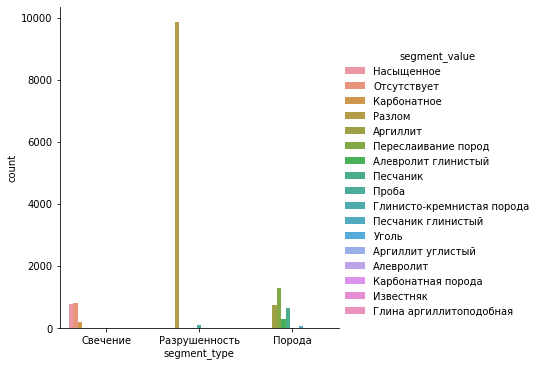

In [ ]:
sns.catplot(x="segment_type", hue="segment_value", kind="count", data=data)

Визуализация распределения segment_value с segment_type == 'Свечение'

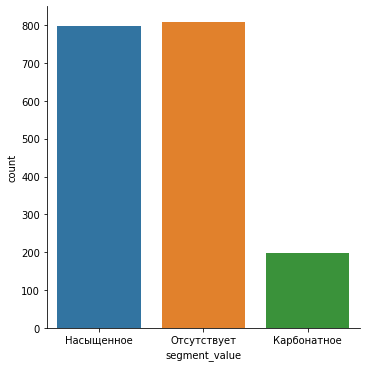

In [ ]:
sns.catplot(x="segment_value", kind="count", data=data[data['segment_type'] == 'Свечение'])

Визуализация распределения segment_value с segment_type == 'Порода'

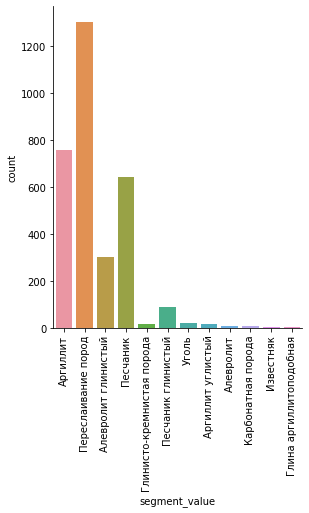

In [ ]:
cp = sns.catplot(x="segment_value", kind="count", data=data[data['segment_type'] == 'Порода'])
plt.xticks(rotation=90)
cp

Поиск уникальных полей в .json

In [ ]:
def get_list_of_json_info_fields(data):
    fields = []
    for i in range(data.shape[0]):
        seg_num = data['segment_num'].iloc[i]
        temp = list(get_json(data, i)[seg_num]['info'].keys())
        for field in temp:
            if not field in fields:
                fields.append(field)
    
    return fields

In [ ]:
fields = get_list_of_json_info_fields(data)
fields

['Интенсивность',
 'Характер',
 'Тип',
 'Цвет',
 'Текстура',
 'Целостность',
 'Крепость',
 'Трещиноватость',
 'Форма трещин',
 'Степень заполнения',
 'Происхождение',
 'Состав',
 'Ихнофоссилии',
 'Состав заполнения']

Создание датасета с колонками fields

In [ ]:
def get_data_with_json_fields(data, fields):
    df = copy.deepcopy(data)
    for field in fields:
        df[field] = np.nan

    for i in range(df.shape[0]):
        seg_num = data['segment_num'].iloc[i]
        temp = get_json(df, i)[seg_num]['info']
        for field in fields:
            if field in temp:
                s = ', '.join(temp[field])
                df[field].iloc[i] = s
    
    return df

In [ ]:
df = get_data_with_json_fields(data, fields)

In [ ]:
df

,task_id,photo_id,photo_type,segment_num,segment_type,segment_value,Интенсивность,Характер,Тип,Цвет,Текстура,Целостность,Крепость,Трещиноватость,Форма трещин,Степень заполнения,Происхождение,Состав,Ихнофоссилии,Состав заполнения
0,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,0,Свечение,Насыщенное,Среднее,Полосчатое,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c6a24494_7931_4ca9_a148_f1fd9785b607,1012473,УФ,1,Свечение,Отсутствует,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cfb8e7b2_7c98_4bd4_897d_0e5e95801bc9,1016625,УФ,0,Свечение,Карбонатное,NaN,NaN,Известковый,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a9d8f546_9046_46ce_ba17_abda344a0980,1013361,УФ,0,Свечение,Карбонатное,NaN,NaN,Известковистый,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,eb09a8aa_6c77_41de_8489_f5a390c789e8,1016727,УФ,0,Свечение,Карбонатное,NaN,NaN,Известковый,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14910,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,6,Разрушенность,Разлом,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14911,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,7,Разрушенность,Разлом,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14912,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,8,Разрушенность,Разлом,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14913,de63ac27_e98e_459a_9672_b07415228a50,1009408,ДС,9,Разрушенность,Разлом,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Просмотр уникальных полей для каждой колонки нового датасета (кроме Ихнофоссилии и Текстуры)

In [ ]:
count = 0
for label, content in df.iteritems():
    if content.unique().shape[0] < 150:
        print(label, ' : ', content.unique())
        count += 1
print(len(fields), count - 4)

photo_type  :  ['УФ' 'ДС']
segment_num  :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
segment_type  :  ['Свечение' 'Разрушенность' 'Порода']
segment_value  :  ['Насыщенное' 'Отсутствует' 'Карбонатное' 'Разлом' 'Аргиллит'
 'Переслаивание пород' 'Алевролит глинистый' 'Песчаник' 'Проба'
 'Глинисто-кремнистая порода' 'Песчаник глинистый' 'Уголь'
 'Аргиллит углистый' 'Алевролит' 'Карбонатная порода' 'Известняк'
 'Глина аргиллитоподобная']
Интенсивность  :  ['Среднее' nan 'Сильное' 'Слабое']
Характер  :  ['Полосчатое' nan 'Пятнистое' 'Сплошное']
Тип  :  [nan 'Известковый' 'Известковистый']
Цвет  :  [nan 'Зеленовато-серый' 'Серый' 'Темно-серый' 'Светло-серый' 'Бурый'
 'Черный' 'Светло-серый с буроватым оттенком' 'Серо-коричневый'
 'Черный с жирным блеском' 'Черный со стеклянным блеском']
Целостность  :  [nan 'Разрушен' 'Не р